# Milestone 3

## Zamiana zmiennych kategorycznych

Po konsultacjach zdecydowaliśmy się pogrupować zmienną 'Branch' w trzy grupy, ze względu na medianę dochodów w danych miastach zgodnie z danymi ze strony [U.S. Census Bureau](https://www.census.gov/)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

df = pd.read_csv("data/banking_dataset.csv", sep=";")
df = df.drop(['Account ID', 'Customer Name'], axis = 1)
df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

In [27]:
high_income = ['San Diego']
medium_income = ['Los Angeles', 'New York', 'Phoenix', 'Chicago']
low_income = ['San Antonio', 'Houston', 'Philadelphia']

def classify_income(city):
    if city in high_income:
        return 'High'
    elif city in medium_income:
        return 'Medium'
    elif city in low_income:
        return 'Low'
    else:
        return 'Unknown'

In [28]:
df['Income_Level'] = df['Branch'].apply(classify_income)

In [29]:
df['Income_Level'].value_counts()

Income_Level
Medium    5037
Low       3780
High      1183
Name: count, dtype: int64

In [30]:
df['Activity_Ratio'] = df['Account Balance'] / (df['Transaction Amount'] + 1)

In [31]:
df.drop('Branch', axis=1)
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency,Income_Level,Activity_Ratio
0,Recurring Deposit,New York,Debit,2687.19,36676.19,GBP,Medium,13.643452
1,Recurring Deposit,Houston,Debit,3886.77,28582.82,USD,Low,7.351983
2,Current,New York,Credit,2438.74,76599.56,GBP,Medium,31.396608
3,Recurring Deposit,Philadelphia,Credit,2758.53,62317.60,INR,Low,22.582686
4,Current,Philadelphia,Debit,3287.00,85515.21,INR,Low,26.008276


Pomiędzy zmiennymi kategorycznymi liczymy współczynnik V Cramera. Dla porównania zmiennych numerycznych zwykła korelacja. Dla kategoryczna vs numeryczna przeprowadzimy analizę wariancji (ANOVA) poniżej

In [32]:
from scipy.stats import chi2_contingency

# Example: Assuming df contains both categorical and numerical variables
categorical_vars = ['Account Type', 'Transaction Type', 'Currency', 'Income_Level']
numeric_vars = ['Transaction Amount', 'Account Balance', 'Activity_Ratio']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

labels = numeric_vars + categorical_vars
matrix = pd.DataFrame(index=labels, columns=labels)

for i in labels:
    for j in labels:
        if i in numeric_vars and j in numeric_vars:
            corr = df[i].corr(df[j])
        elif i in categorical_vars and j in categorical_vars:
            corr = cramers_v(df[i], df[j])
        elif i in categorical_vars and j in numeric_vars:
            corr = 0
        elif i in numeric_vars and j in categorical_vars:
            corr = 0
        else:
            corr = np.nan
        matrix.loc[i, j] = round(corr, 3)

matrix = matrix.astype(float)

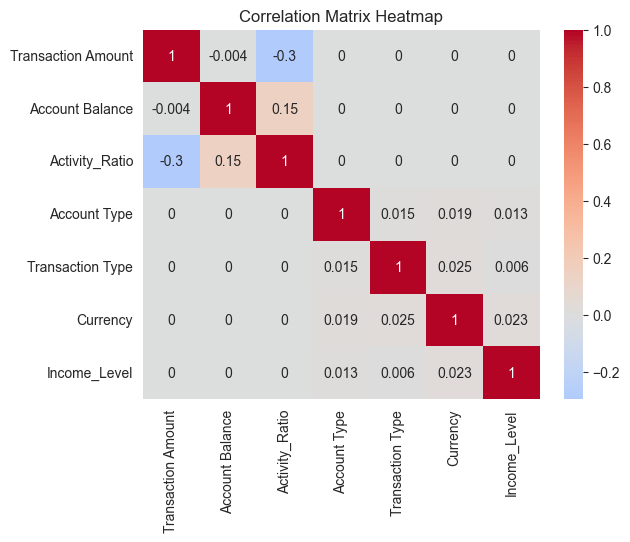

In [33]:
sns.heatmap(matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [34]:
from scipy.stats import f_oneway

def anova(numerical_var):

    data = df.copy()

    anova_results = {}

    for categorical_var in ['Account Type', 'Income_Level', 'Transaction Type', 'Currency']:

        groups = data[categorical_var].unique()

        group_data = [data[data[categorical_var] == group][numerical_var] for group in groups]

        anova_result = f_oneway(*group_data)

        anova_results[categorical_var] = {
            'F-statistic': anova_result.statistic,
            'p-value': anova_result.pvalue
        }

    return anova_results

In [35]:
anova('Transaction Amount')

{'Account Type': {'F-statistic': np.float64(0.4960380614993981),
  'p-value': np.float64(0.685024676757283)},
 'Income_Level': {'F-statistic': np.float64(0.18127183558846943),
  'p-value': np.float64(0.8342113022241587)},
 'Transaction Type': {'F-statistic': np.float64(0.04434097280030259),
  'p-value': np.float64(0.8332248027402385)},
 'Currency': {'F-statistic': np.float64(0.7868511206355585),
  'p-value': np.float64(0.5334971255798454)}}

In [36]:
anova('Account Balance')

{'Account Type': {'F-statistic': np.float64(0.36155523171449355),
  'p-value': np.float64(0.7807781859407651)},
 'Income_Level': {'F-statistic': np.float64(0.9524120912430275),
  'p-value': np.float64(0.3858442969567153)},
 'Transaction Type': {'F-statistic': np.float64(0.7776175298494202),
  'p-value': np.float64(0.377891974902812)},
 'Currency': {'F-statistic': np.float64(0.5936890160103484),
  'p-value': np.float64(0.6672020417903477)}}

In [37]:
anova('Activity_Ratio')

{'Account Type': {'F-statistic': np.float64(0.02666275482452247),
  'p-value': np.float64(0.9941252414317571)},
 'Income_Level': {'F-statistic': np.float64(0.9402963344771678),
  'p-value': np.float64(0.39054663098291076)},
 'Transaction Type': {'F-statistic': np.float64(1.855427028795416),
  'p-value': np.float64(0.17318420236268703)},
 'Currency': {'F-statistic': np.float64(0.5898878672564212),
  'p-value': np.float64(0.6699566622636077)}}

Nie możemy stwierdzić, aby podział na grupy przez zmienne kategoryczne wpływał na średnie wartości zmiennych numerycznych.

## Dalsze porównania metod klastrowania oraz metody wizualizacji

Pozbywamy się Branch na rzecz zmiennej Income_Level, oraz zmiennej Currency ponieważ wartości numeryczne są w dolarach (tak mówi autor ramki danych)

In [40]:
df = df.drop(['Branch', 'Currency'], axis=1)
df.head()

,Account Type,Transaction Type,Transaction Amount,Account Balance,Income_Level,Activity_Ratio
0,Recurring Deposit,Debit,2687.19,36676.19,Medium,13.643452
1,Recurring Deposit,Debit,3886.77,28582.82,Low,7.351983
2,Current,Credit,2438.74,76599.56,Medium,31.396608
3,Recurring Deposit,Credit,2758.53,62317.60,Low,22.582686
4,Current,Debit,3287.00,85515.21,Low,26.008276


In [43]:
from sklearn.preprocessing import LabelEncoder

df_le = df.copy()

le = LabelEncoder()

df_le['Account Type'] = le.fit_transform(df_le['Account Type'])
df_le['Transaction Type'] = le.fit_transform(df_le['Transaction Type'])
df_le['Income_Level'] = le.fit_transform(df_le['Income_Level'])

In [44]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df1 = df_le.copy()

X = df1.values

# t-SNE dla nieprzekształconych danych
tsne_raw = TSNE(n_components=2, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X)

# 2. t-SNE dla danych po normalizacji
X_minmax = MinMaxScaler().fit_transform(X)
X_tsne_minmax = TSNE(n_components=2, random_state=42).fit_transform(X_minmax)

# 3. t-SNE dla danych po standaryzacji
X_standard = StandardScaler().fit_transform(X)
X_tsne_standard = TSNE(n_components=2, random_state=42).fit_transform(X_standard)

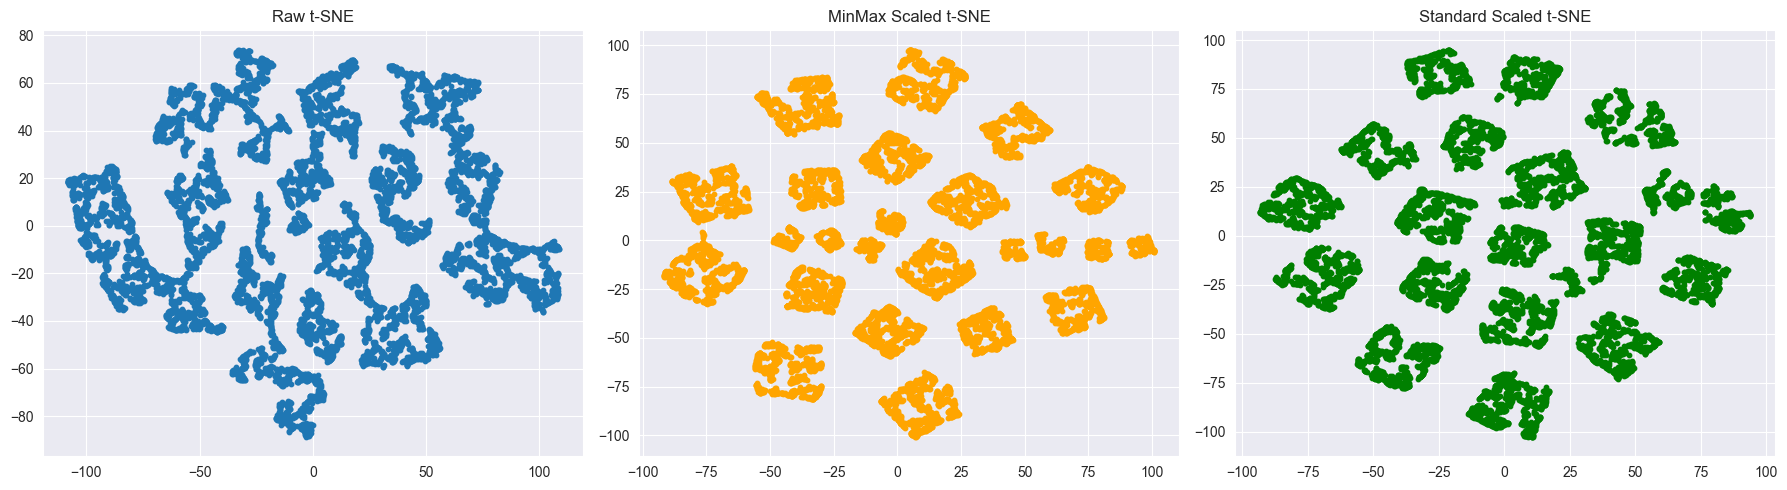

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1], s=10)
axes[0].set_title('Raw t-SNE')

axes[1].scatter(X_tsne_minmax[:, 0], X_tsne_minmax[:, 1], s=10, c='orange')
axes[1].set_title('MinMax Scaled t-SNE')

axes[2].scatter(X_tsne_standard[:, 0], X_tsne_standard[:, 1], s=10, c='green')
axes[2].set_title('Standard Scaled t-SNE')

plt.tight_layout()
plt.show()

In [117]:
from sklearn.cluster import DBSCAN
dbscan_minmax = DBSCAN(eps=0.3, min_samples=5).fit(X_minmax)

In [118]:
dbscan_standard = DBSCAN(eps=0.5, min_samples=5).fit(X_standard)

In [89]:
tsne_3d = TSNE(n_components=3, random_state=42)
X_3d_tsne_minmax = tsne_3d.fit_transform(X_minmax)

In [90]:
X_3d_tsne_standard = tsne_3d.fit_transform(X_standard)

In [134]:
import plotly.graph_objects as go
import plotly.express as px

labels = dbscan_minmax.labels_
color_array = np.where(labels == -1, 'black', labels)
colors = px.colors.qualitative.Light24
label_colors = [colors[i % len(colors)] if i != -1 else 'black' for i in labels]

fig = go.Figure(data=[go.Scatter3d(
    x=X_3d_tsne_minmax[:, 0],
    y=X_3d_tsne_minmax[:, 1],
    z=X_3d_tsne_minmax[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label_colors,
        opacity=0.4,
    )
)])

fig.update_layout(
    title='Interactive 3D t-SNE Visualization',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [130]:
import plotly.graph_objects as go

labels = dbscan_standard.labels_
color_array = np.where(labels == -1, 'black', labels)
colors = px.colors.qualitative.Light24
label_colors = [colors[i % len(colors)] if i != -1 else 'black' for i in labels]

fig = go.Figure(data=[go.Scatter3d(
    x=X_3d_tsne_standard[:, 0],
    y=X_3d_tsne_standard[:, 1],
    z=X_3d_tsne_standard[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label_colors,
        opacity=0.4,
    )
)])

fig.update_layout(
    title='Interactive 3D t-SNE Visualization',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [93]:
import umap

X_3d_umap_minmax = umap.UMAP(random_state=42, n_components=3).fit_transform(X_minmax)

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [139]:
labels = dbscan_minmax.labels_
color_array = np.where(labels == -1, 'black', labels)
colors = px.colors.qualitative.Light24
label_colors = [colors[i % len(colors)] if i != -1 else 'black' for i in labels]

fig = go.Figure(data=[go.Scatter3d(
    x=X_3d_umap_minmax[:, 0],
    y=X_3d_umap_minmax[:, 1],
    z=X_3d_umap_minmax[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label_colors,
        opacity=0.4,
    )
)])

fig.update_layout(
    title='Interactive 3D UMAP Visualization',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [135]:
X_3d_umap_standard = umap.UMAP(random_state=42, n_components=3).fit_transform(X_standard)

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Wojtek\Documents\ML\klasteryzacja\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [140]:
labels = dbscan_standard.labels_
color_array = np.where(labels == -1, 'black', labels)
colors = px.colors.qualitative.Light24
label_colors = [colors[i % len(colors)] if i != -1 else 'black' for i in labels]

fig = go.Figure(data=[go.Scatter3d(
    x=X_3d_umap_standard[:, 0],
    y=X_3d_umap_standard[:, 1],
    z=X_3d_umap_standard[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label_colors,
        opacity=0.4,
    )
)])

fig.update_layout(
    title='Interactive 3D UMAP Visualization',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

TO DO: kmeans i agglomerative wraz z metrykami, nastepnie interpretacja